# INTRO

[INFO] NaNs found — applying nearest-neighbor extrapolation
splitting mesh!


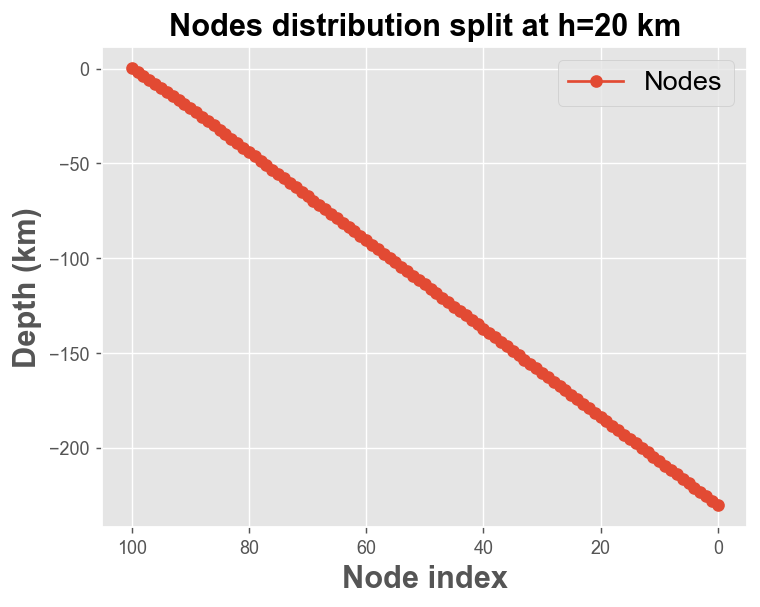

/home/francesco/Scaricati/msh3lay/m.c.3dg.25


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from pathlib import Path
import generate_3D_structured_mesh_V0 as smesh
TopoFile = 'm.cal.dat' #topo file strict rectangular boundaries
EVENT='IONIO2025'
surface = np.loadtxt(TopoFile)
x1 = surface[:,0]
y1 = surface[:,1]
z1 = surface[:,2]
xmin = min(x1);xmax = max(x1)
ymin = min(y1);ymax = max(y1)
zmin = -230000; zmax = max(z1)#depth of model
totalx = xmax-xmin;totaly = ymax-ymin
nx = 118  # number of grid points in X direction
ny = 171  # number of grid points in X direction
nz = 101 # number of grid points in Z direction
total_elem = nx*ny*nz; x_length = (x1.max() - x1.min())
y_length = (y1.max() - y1.min()); z_length = (abs(zmin) + zmax)
assert xmin >= x1.min() and xmax <= x1.max(), "[ERROR] x-domain exceeds topo bounds"
assert ymin >= y1.min() and ymax <= y1.max(), "[ERROR] y-domain exceeds topo bounds"
filename_VTK = f'iclarc_{EVENT}.vtk' 
split_depth = -(20000) # depth of the split with respect to the surface
nlower_nodes = 91
smesh.VTK_3D_mesh(nx,ny,nz,xmin,xmax,ymin,ymax,zmin,zmax,split_depth,nlower_nodes,filename_VTK,TopoFile=TopoFile,TOPO=True,READ_TOPO=True,WRITE_SpecFEM_Files=True,TOMO_MODEL=True,SPLIT_MESH=True)
filename = f"{nx}_{ny}_{nz}_{EVENT}.txt"
with open(filename, "w") as file:
    file.write("===========valori============\n")
    file.write(f"Total number of elements: {total_elem}, grid points x: {nx}, grid points y: {ny}, grid points z: {nz}\n")
    file.write(f"X length (E–W): {x_length:.2f}m, Y length (N–S): {y_length:.2f}m, Z depth (UP–DOWN): {z_length:.2f}m\n")
    file.write(f"Spacing x direction: {x_length/(nx-1):.2f}m, y direction: {y_length/(ny-1):.2f}m, z direction: {z_length/(nz-1):.2f}m\n")
    file.write(f"TOMO: xmin,xmax: {xmin}, {xmax}, ymin,ymax: {ymin}, {ymax}, zmin,zmax: {zmin}, {zmax}\n")
    file.write(f"Split depth: {abs(split_depth *10e-4)} km\n")
    file.write("============================\n")
!pwd

In [ ]:
!pwd
# create the velocity file
material_domain_id = 2 # 1=acoustic / 2=elastic
fname = f'{nx}_{ny}_{nz}_{EVENT}.xyz' # select the name of your tomographic model
smesh.write_tomographic_materials_file(material_domain_id,fname)

## STF FUNCTION

In [15]:
filepath="/home/francesco/sorgenti"
#read Par_file -----> Time step same as DT, Tot. # of steps same as NSTEP 
DT, NSTEP = 0.0020 , 120000
from pathlib import Path
import re
event_lines = {}
event_pattern = re.compile(r'\b[A-Z]{3,}[12][0-9]{3}\b')
with Path(filepath).open('r', encoding='utf-8') as file:
    for line in file:
        match = event_pattern.search(line)
        if match:
            event_name = match.group()
            event_lines[event_name] = line.strip()
print("Available events found in 'sorgenti':")
for i, name in enumerate(event_lines, start=1):
    print(f"{i}. {name}")
while True:
    selected = input("Enter the name of the event you want to select (e.g., GRECIA2024): ").strip().upper()
    if selected in event_lines:
        EVENT = selected
        print(f"\nSelected EVENT: {EVENT}")
        print(f"Line content: {event_lines[EVENT]}")
        break
    else:
        print("Invalid selection. No matching events found. Try again.")
print(f"DT: {DT:.5f}; ", f"NSTEP: {NSTEP:.0f}; ", f"Total time: {NSTEP*DT:.3f}", 's.')

Available events found in 'sorgenti':
1. PIIETRAPAOLA2024
2. CATZLIDO2022
3. IONIO2025
4. IONIO2012
5. IONIO2014
6. GRECIA2024
7. GRECIA2022
8. GRECIA2020
9. GRECIA2019
10. GRECIA2018


Enter the name of the event you want to select (e.g., GRECIA2024):  IONIO2025



Selected EVENT: IONIO2025
Line content: IONIO2025 39 KM 2025 4 16 4,7
DT: 0.00200;  NSTEP: 120000;  Total time: 240.000 s.


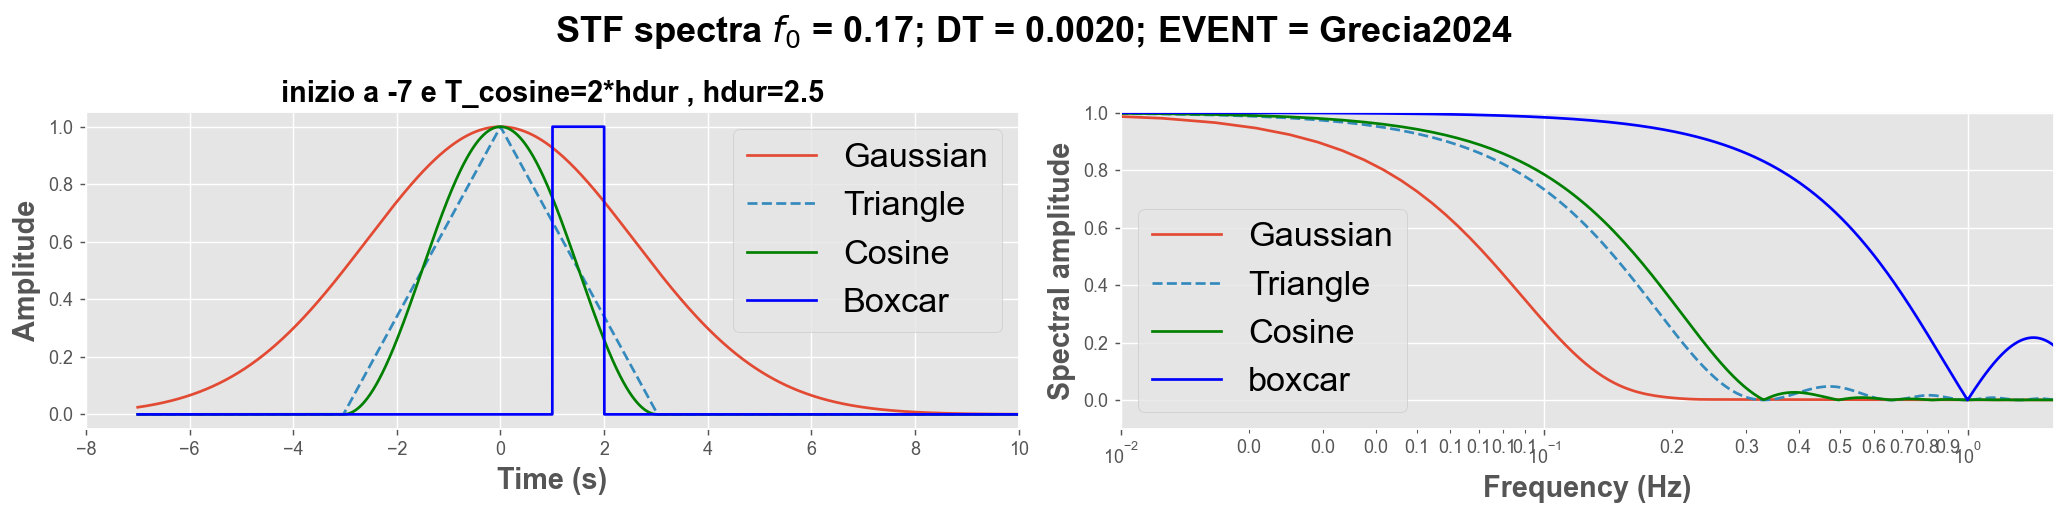

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from matplotlib.ticker import FormatStrFormatter
dt = 0.0020
TIME=233
TIME1=-7
t = np.arange(TIME1, TIME, dt)
n = len(t)
#BOXCAR
boxcar_start = 1.0
boxcar_duration = 1.0
boxcar_end = boxcar_start + boxcar_duration
cdt_box = (t >= boxcar_start) & (t <= boxcar_end)
boxcar_stf = np.zeros_like(t)
boxcar_stf[cdt_box] = 1.0
# Triangle STF (symmetric, peak at t=0, half-duration 18 s)
hdur = 3.03  # half duration
triangle = np.maximum(0, 1 - np.abs(t) / hdur)
triangle /= np.max(triangle)  # normalize
# Gaussian STF (standard deviation chosen to visually match the triangle's width)
std_dev = hdur / np.sqrt(2 * np.log(2))  # FWHM to std
gaussian = np.exp(-0.5 * (t / std_dev) ** 2)
gaussian /= np.max(gaussian)  # normalize
#cosine stf
T = 2 * hdur  #durata della cosine:proakis1986
pad = 2.0     #durata zeri prima e dop
n_total = int(T / dt)
n_pad = int(pad / dt)
n_main = n_total - 2 * n_pad
t = np.arange(TIME1, TIME, dt)
cosine = np.zeros_like(t)
mask = (t >= -hdur) & (t <= hdur)
cosine[mask] = 0.5 * (1 - np.cos(2 * np.pi * (t[mask] + hdur) / T))
#ffts
freq = fftshift(fftfreq(n, d=dt))
triangle_fft = np.abs(fftshift(fft(triangle)))
gaussian_fft = np.abs(fftshift(fft(gaussian)))
triangle_fft /= np.max(triangle_fft)
gaussian_fft /= np.max(gaussian_fft)
cosine_fft = np.abs(fftshift(fft(cosine)))
cosine_fft /= np.max(cosine_fft)
box_fft = np.abs(fftshift(fft(boxcar_stf)))
box_fft /= np.max(box_fft)         
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(t, gaussian, label="Gaussian", linestyle='-')
plt.plot(t, triangle, label="Triangle", linestyle='--')
plt.plot(t, cosine, label='Cosine', c='g')
plt.plot(t, boxcar_stf, c='blue', label='Boxcar')
plt.xlabel("Time (s)", fontsize=16, fontweight='bold')
plt.ylabel("Amplitude", fontsize=16, fontweight='bold')
plt.title(f'inizio a %d e T_cosine=2*hdur , hdur=2.5' % (TIME1), fontsize=16, fontweight='bold')
plt.xlim(-8,10)
plt.legend(fontsize=19)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.semilogx(freq[freq > 0], gaussian_fft[freq > 0], label="Gaussian", linestyle='-')
plt.semilogx(freq[freq > 0], triangle_fft[freq > 0], label="Triangle", linestyle='--')
plt.semilogx(freq[freq > 0], cosine_fft[freq > 0], label="Cosine", c='g')
plt.semilogx(freq[freq > 0], box_fft[freq > 0], label="boxcar", c='b')
ax= plt.gca()
ax.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
plt.xlabel("Frequency (Hz)", fontsize=16, fontweight='bold')
plt.ylabel("Spectral amplitude", fontsize=16, fontweight='bold')
plt.suptitle(r'STF spectra $f_0$ = {:.2f}; DT = {:.4f}; EVENT = {}'.format(1/T, dt, EVENT),
             fontsize=20, fontweight='bold')
plt.legend(loc='lower left', fontsize=19)
plt.ylim(-0.1, 1.001)
plt.xlim(0.01, 1.6)
plt.tight_layout()
plt.savefig('stfs_1.png',dpi=85)
plt.show()

In [ ]:
np.savetxt("stf_box.txt", boxcar_stf, fmt="%.17e")
np.savetxt("stf_iclarc_grecia.txt", cosine, fmt="%.5f")
np.savetxt("stf_iclarc_grecia.txt", gaussian, fmt="%.5f")

In [ ]:
# create the velocity file
material_domain_id = 2 # 1=acoustic / 2=elastic
fname = '3dcatlido.xyz' # select the name of your tomographic model
smesh.write_tomographic_materials_file(material_domain_id,fname)

## simutils

# slices

In [1]:
#NZ, NY or NX are the slice_index that you are plotting
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
plt.rcParams['figure.dpi']=130
plt.rcParams['font.sans-serif']='Arial'
plt.style.use('ggplot')
def plt_vrtcl_vp(array, slice_axis='Y', slice_index=0, output_folder='./vrtcl_vp'):
    """
    Plot vertical slice of array at a given index along X or Y axis.
    :param array: np.array with shape (N, 6)
    :param slice_axis: 'X' or 'Y' - axis along which to take constant slices
    :param slice_index: index of the unique slice values along chosen axis
    :param output_folder: str, path to folder where figure is saved
    """
    if slice_axis not in ['X', 'Y']:
        raise ValueError("slice_axis must be 'X' or 'Y'.")
    axis_col = 0 if slice_axis == 'X' else 1
    unique_vals = np.unique(array[:, axis_col])
    if slice_index >= len(unique_vals):
        print(f"slice index {slice_index} exceeds available slices ({len(unique_vals)}). Skipping.")
        return
    slice_value = unique_vals[slice_index]
    slice_data = array[array[:, axis_col] == slice_value]
    if slice_data.size == 0:
        print(f"No data found for {slice_axis} = {slice_value}. Skipping.")
        return
    #sort depth for clean plotting
    #slice_data = slice_data[slice_data[:, 2].argsort()]
    plt.figure(figsize=(10, 8))
    scatter_axis = 0 if slice_axis == 'Y' else 1  # Plot X if Y is constant, Y if X is constant
    plt.scatter(slice_data[:,scatter_axis]*1e-3, slice_data[:,2]*1e-3, c=slice_data[:,3]*1e-3, cmap='seismic')
    cbar=plt.colorbar(label='$V_p \,(km/s)$',spacing='proportional',orientation='vertical')
    cbar.set_label(label='$V_p \, (km/s)$',size=30,weight='bold')
    cbar.ax.tick_params(labelsize=25,pad=0.9,length=0.5,width=0.5)
    plt.title(f'P-wave velocity for slice at {slice_axis} = {slice_value * 1e-3:.3f} km',fontsize=21,fontweight='bold')
    plt.xlabel(f'{"X (km)" if slice_axis=="Y" else "Y (km)"}',fontsize=25,fontweight='bold')
    plt.ylabel('Depth (km)',fontsize=25,fontweight='bold')
    plt.xticks(fontsize=19,weight='bold')
    plt.yticks(fontsize=25,weight='bold')
    #plt.gca().invert_yaxis()  
    os.makedirs(output_folder, exist_ok=True)
    save_path = os.path.join(output_folder, f'vert_slice_vp_{slice_axis}_{slice_index:03d}.png')
    plt.savefig(save_path, dpi=80)
    plt.close()
def plt_vrtcl_vs(array, slice_axis='Y', slice_index=0, output_folder='./vrtcl_vs'):
    """
    Plot vertical slice of array at a given index along X or Y axis.
    :param array: np.array with shape (N, 6)
    :param slice_axis: 'X' or 'Y' - axis along which to take constant slices
    :param slice_index: index of the unique slice values along chosen axis
    :param output_folder: str, path to folder where figure is saved
    """
    if slice_axis not in ['X', 'Y']:
        raise ValueError("slice_axis must be 'X' or 'Y'.")
    axis_col = 0 if slice_axis == 'X' else 1
    unique_vals = np.unique(array[:, axis_col])
    if slice_index >= len(unique_vals):
        print(f"slice index {slice_index} exceeds available slices ({len(unique_vals)}). Skipping.")
        return
    slice_value = unique_vals[slice_index]
    slice_data = array[array[:, axis_col] == slice_value]
    if slice_data.size == 0:
        print(f"No data found for {slice_axis} = {slice_value}. Skipping.")
        return
    # Sorting by depth for clean plotting
    #slice_data = slice_data[slice_data[:, 2].argsort()]
    plt.figure(figsize=(10, 8))
    scatter_axis = 0 if slice_axis == 'Y' else 1  # Plot X if Y is constant, Y if X is constant
    plt.scatter(slice_data[:,scatter_axis]*1e-3, slice_data[:,2]*1e-3, c=slice_data[:,4]*1e-3, cmap='seismic')
    cbar=plt.colorbar(label='$V_s \, (km/s)$',spacing='proportional',orientation='vertical')
    cbar.set_label(label=r'$V_s \,(km/s)$',size=30,weight='bold')
    cbar.ax.tick_params(labelsize=25,pad=0.9,length=0.5,width=0.5)
    plt.title(f'S-wave velocity for slice at {slice_axis} = {slice_value * 1e-3:.3f} km',fontsize=21,fontweight='bold')
    plt.xlabel(f'{"X (km)" if slice_axis=="Y" else "Y (km)"}',fontsize=25,fontweight='bold')
    plt.ylabel('Depth (km)',fontsize=25,fontweight='bold')
    plt.xticks(fontsize=19,weight='bold')
    plt.yticks(fontsize=25,weight='bold')
    #plt.gca().invert_yaxis()  
    os.makedirs(output_folder, exist_ok=True)
    save_path = os.path.join(output_folder, f'vert_slice_vs_{slice_axis}_{slice_index:03d}.png')
    plt.savefig(save_path, dpi=80)
    plt.close()
def plt_vrtcl_rho(array, slice_axis='Y', slice_index=0, output_folder='./vrtcl_rho'):
    """
    Plot vertical slice of array at a given index along X or Y axis.
    :param array: np.array with shape (N, 6)
    :param slice_axis: 'X' or 'Y' - axis along which to take constant slices
    :param slice_index: index of the unique slice values along chosen axis
    :param output_folder: str, path to folder where figure is saved
    """
    if slice_axis not in ['X', 'Y']:
        raise ValueError("slice_axis must be 'X' or 'Y'.")
    axis_col = 0 if slice_axis == 'X' else 1
    unique_vals = np.unique(array[:, axis_col])
    if slice_index >= len(unique_vals):
        print(f"slice index {slice_index} exceeds available slices ({len(unique_vals)}). Skipping.")
        return
    slice_value = unique_vals[slice_index]
    slice_data = array[array[:, axis_col] == slice_value]
    if slice_data.size == 0:
        print(f"No data found for {slice_axis} = {slice_value}. Skipping.")
        return
    # Sorting by depth for clean plotting
    #slice_data = slice_data[slice_data[:, 2].argsort()]
    plt.figure(figsize=(10, 8))
    scatter_axis = 0 if slice_axis == 'Y' else 1  # Plot X if Y is constant, Y if X is constant
    plt.scatter(slice_data[:,scatter_axis]*1e-3, slice_data[:,2]*1e-3, c=slice_data[:,5]*1e-3, cmap='managua')
    cbar=plt.colorbar(label=r'$\rho \,(g/cm^{3})$',spacing='proportional',orientation='vertical')
    cbar.set_label(label=r'$\rho \,(g/cm^{3})$',size=30,weight='bold')
    cbar.ax.tick_params(labelsize=25,pad=0.9,length=0.5,width=0.5)
    plt.title(f'Density value for slice at {slice_axis} = {slice_value * 1e-3:.3f} km',fontsize=21,fontweight='bold')
    plt.xlabel(f'{"X (km)" if slice_axis=="Y" else "Y (km)"}',fontsize=25,fontweight='bold')
    plt.ylabel('Depth (km)',fontsize=25,fontweight='bold')
    plt.xticks(fontsize=19,weight='bold')
    plt.yticks(fontsize=25,weight='bold')
    #plt.gca().invert_yaxis()  
    os.makedirs(output_folder, exist_ok=True)
    save_path = os.path.join(output_folder, f'vert_slice_rho_{slice_axis}_{slice_index:03d}.png')
    plt.savefig(save_path, dpi=80)
    plt.close()
def plt_vrtcl_qp(array, slice_axis='Y', slice_index=0, output_folder='./vrtcl_qp'):
    """
    Plot vertical slice of array at a given index along X or Y axis.
    :param array: np.array with shape (N, 8)
    :param slice_axis: 'X' or 'Y' - axis along which to take constant slices
    :param slice_index: index of the unique slice values along chosen axis
    :param output_folder: str, path to folder where figure is saved
    """
    if slice_axis not in ['X', 'Y']:
        raise ValueError("slice_axis must be 'X' or 'Y'.")
    axis_col = 0 if slice_axis == 'X' else 1
    unique_vals = np.unique(array[:, axis_col])
    if slice_index >= len(unique_vals):
        print(f"slice index {slice_index} exceeds available slices ({len(unique_vals)}). Skipping.")
        return
    slice_value = unique_vals[slice_index]
    slice_data = array[array[:, axis_col] == slice_value]
    if slice_data.size == 0:
        print(f"No data found for {slice_axis} = {slice_value}. Skipping.")
        return
    # Sorting by depth for clean plotting
    #slice_data = slice_data[slice_data[:, 2].argsort()]
    plt.figure(figsize=(10, 8))
    scatter_axis = 0 if slice_axis == 'Y' else 1  # Plot X if Y is constant, Y if X is constant
    plt.scatter(slice_data[:,scatter_axis]*1e-3, slice_data[:,2]*1e-3, c=slice_data[:,6], cmap='summer')
    cbar=plt.colorbar(label=r'$Q_p $',spacing='proportional',orientation='vertical')
    cbar.set_label(label=r'$Q_p$',size=30,weight='bold')
    cbar.ax.tick_params(labelsize=25,pad=0.9,length=0.5,width=0.5)
    plt.title(f'P-wave attenuation value for slice at {slice_axis} = {slice_value * 1e-3:.3f} km',fontsize=21,fontweight='bold')
    plt.xlabel(f'{"X (km)" if slice_axis=="Y" else "Y (km)"}',fontsize=25,fontweight='bold')
    plt.ylabel('Depth (km)',fontsize=25,fontweight='bold')
    plt.xticks(fontsize=19,weight='bold')
    plt.yticks(fontsize=25,weight='bold')
    #plt.gca().invert_yaxis()  
    os.makedirs(output_folder, exist_ok=True)
    save_path = os.path.join(output_folder, f'vert_slice_qp_{slice_axis}_{slice_index:03d}.png')
    plt.savefig(save_path, dpi=80)
    plt.close()
def plt_vrtcl_qs(array, slice_axis='Y', slice_index=0, output_folder='./vrtcl_qs'):
    """
    Plot vertical slice of array at a given index along X or Y axis.
    :param array: np.array with shape (N, 6)
    :param slice_axis: 'X' or 'Y' - axis along which to take constant slices
    :param slice_index: index of the unique slice values along chosen axis
    :param output_folder: str, path to folder where figure is saved
    """
    if slice_axis not in ['X', 'Y']:
        raise ValueError("slice_axis must be 'X' or 'Y'.")
    axis_col = 0 if slice_axis == 'X' else 1
    unique_vals = np.unique(array[:, axis_col])
    if slice_index >= len(unique_vals):
        print(f"slice index {slice_index} exceeds available slices ({len(unique_vals)}). Skipping.")
        return
    slice_value = unique_vals[slice_index]
    slice_data = array[array[:, axis_col] == slice_value]
    if slice_data.size == 0:
        print(f"No data found for {slice_axis} = {slice_value}. Skipping.")
        return
    # Sorting by depth for clean plotting
    #slice_data = slice_data[slice_data[:, 2].argsort()]
    plt.figure(figsize=(10, 8))
    scatter_axis = 0 if slice_axis == 'Y' else 1  # Plot X if Y is constant, Y if X is constant
    plt.scatter(slice_data[:,scatter_axis]*1e-3, slice_data[:,2]*1e-3, c=slice_data[:,7], cmap='autumn')
    cbar=plt.colorbar(label=r'$Q_S$',spacing='proportional',orientation='vertical')
    cbar.set_label(label=r'$Q_S$',size=30,weight='bold')
    cbar.ax.tick_params(labelsize=25,pad=0.9,length=0.5,width=0.5)
    plt.title(f'S-wave attenaution value for slice at {slice_axis} = {slice_value * 1e-3:.3f} km',fontsize=21,fontweight='bold')
    plt.xlabel(f'{"X (km)" if slice_axis=="Y" else "Y (km)"}',fontsize=25,fontweight='bold')
    plt.ylabel('Depth (km)',fontsize=25,fontweight='bold')
    plt.xticks(fontsize=19,weight='bold')
    plt.yticks(fontsize=25,weight='bold')
    #plt.gca().invert_yaxis()  
    os.makedirs(output_folder, exist_ok=True)
    save_path = os.path.join(output_folder, f'vert_slice_qs_{slice_axis}_{slice_index:03d}.png')
    plt.savefig(save_path, dpi=80)
    plt.close()
def plt_vrtcl_vpvs(array, slice_axis='Y', slice_index=0, output_folder='./vrtcl_vpvs'):
    """
    Plot vertical slice of Vp/Vs ratio at a given index along X or Y axis.
    :param array: np.array with shape (N, 6)
    :param slice_axis: 'X' or 'Y'
    :param slice_index: index of the unique slice values along chosen axis
    :param output_folder: str
    """
    if slice_axis not in ['X', 'Y']:
        raise ValueError("slice_axis must be 'X' or 'Y'.")
    axis_col = 0 if slice_axis == 'X' else 1
    unique_vals = np.unique(array[:, axis_col])
    if slice_index >= len(unique_vals):
        print(f"slice index {slice_index} exceeds available slices ({len(unique_vals)}). Skipping.")
        return
    slice_value = unique_vals[slice_index]
    slice_data = array[array[:, axis_col] == slice_value]
    if slice_data.size == 0:
        print(f"No data found for {slice_axis} = {slice_value}. Skipping.")
        return

    vp = slice_data[:, 3]
    vs = slice_data[:, 4]
    with np.errstate(divide='ignore', invalid='ignore'):
        vp_vs_ratio = np.where(vs != 0, vp / vs, np.nan)

    plt.figure(figsize=(10, 8))
    scatter_axis = 0 if slice_axis == 'Y' else 1
    sc = plt.scatter(slice_data[:, scatter_axis]*1e-3, slice_data[:, 2]*1e-3,
                     c=vp_vs_ratio, cmap='inferno')
    cbar = plt.colorbar(sc, label=r'$V_p / V_s$', spacing='proportional', orientation='vertical')
    cbar.set_label(label=r'$V_p / V_s$', size=30, weight='bold')
    cbar.ax.tick_params(labelsize=25, pad=0.9, length=0.5, width=0.5)
    plt.title(f'$V_p/V_s$ ratio for slice at {slice_axis} = {slice_value * 1e-3:.3f} km',
              fontsize=21, fontweight='bold')
    plt.xlabel(f'{"X (km)" if slice_axis == "Y" else "Y (km)"}', fontsize=25, fontweight='bold')
    plt.ylabel('Depth (km)', fontsize=25, fontweight='bold')
    plt.xticks(fontsize=19, weight='bold')
    plt.yticks(fontsize=25, weight='bold')
    # plt.gca().invert_yaxis()
    os.makedirs(output_folder, exist_ok=True)
    save_path = os.path.join(output_folder, f'vert_slice_vpvs_{slice_axis}_{slice_index:03d}.png')
    plt.savefig(save_path, dpi=80)
    plt.close()    

In [4]:
fname = '118_171_101_IONIO2025.xyz';nx=118
data = np.loadtxt(fname, skiprows=4)
for i in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_vp(data, slice_axis='X', slice_index=i, output_folder='./vrtcl_vp')
for j in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_vs(data, slice_axis='X', slice_index=j, output_folder='./vrtcl_vs')
for k in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_rho(data, slice_axis='X', slice_index=k, output_folder='./vrtcl_rho')
for l in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_qp(data, slice_axis='X', slice_index=l, output_folder='./vrtcl_qp')
for m in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_qs(data, slice_axis='X', slice_index=m, output_folder='./vrtcl_qs') 
for jk in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_vpvs(data, slice_axis='X', slice_index=jk, output_folder='./vrtcl_vpvs') 

In [2]:
fname = '118_171_101_IONIO2025.xyz';nx=118
data = np.loadtxt(fname, skiprows=4)
for j in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_vs(data, slice_axis='X', slice_index=j, output_folder='./vrtcl_vs')
nx=171
for j in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_vs(data, slice_axis='Y', slice_index=j, output_folder='./vrtcl_vs')

In [5]:
nx=171#Nx=114 Ny=144
for i in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_vp(data, slice_axis='Y', slice_index=i, output_folder='./vrtcl_vp')
for j in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_vs(data, slice_axis='Y', slice_index=j, output_folder='./vrtcl_vs')
for k in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_rho(data, slice_axis='Y', slice_index=k, output_folder='./vrtcl_rho')
for l in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_qp(data, slice_axis='Y', slice_index=l, output_folder='./vrtcl_qp')
for m in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_qs(data, slice_axis='Y', slice_index=m, output_folder='./vrtcl_qs')
for jk in range(0, nx):  # NZ, NY or NX are the slice_index that you are plotting
    plt_vrtcl_vpvs(data, slice_axis='Y', slice_index=jk, output_folder='./vrtcl_vpvs') 